# Journal 01 Core-Periphy Model

This journal introduces the core periphery network and does some analysis of how we can compute the centralities of them in an interesting. This is a method that ought to extend to to general graphs.

# Introduction
A core periphery network is a generalization of the start network but now we $\ell$ fully connected nodes.  Furthermore there is another layer of nodes on the periphery. In this journal each core node will have a directed edge to k peripheral nodes. W Peripheral nodes are only connected to 1 core node. e will describe the number of peripheral nodes in terms of how many peripheral nodes are associated with each core node. We will call this ratio the branching factor

## Example
Below is an example of a core periphery network with a core size of 4 and branching factor from core to periphery of 2. 

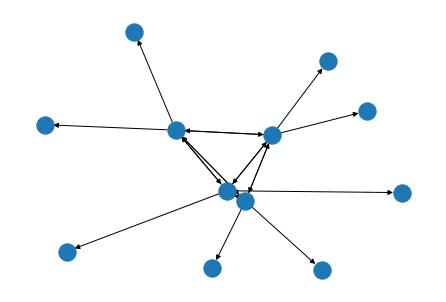

In [23]:
import networkx as nx
import numpy as np
import numpy.linalg as lin
from __future__ import annotations
import matplotlib.pyplot as plt
from helperfunctions.util import *
from helperfunctions.rational import RationalF as Ratio
import itertools    

def make_core_periphy(core_size, branching_factor):
    n = core_size * (1 + branching_factor)
    mat = np.zeros((n,n))
    for i in range(core_size):
        for j in range(core_size):
            if(i == j): continue
            mat[i,j] = 1
    for i in range(core_size, n):
        parent = (i - core_size) // branching_factor 
        mat[parent, i] = 1
    return mat

A = make_core_periphy(4, 2)
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
nx.draw_spring(G)

## Analysis of centrality 
Our goal will now be to compute $(I - \rho (G+G^T))^{-1} 1$ for such a graph. Recall that $(I - \rho (G+G^T))^{-1} 1 = \sum_{i=0}^\infty (\rho (G+G^T))^i 1$ 

Consider the following method to take advantage of the symmetry in this situation. Let $C^n $ be the number of walks of length n in G that end in a a core node and $P^n$ the number of walks of length n that end in Peripheral node. 

For both we have $P^0 = C^0 = 1$ and for $n > 0$ we can get a set of recursive formulas by looking at the connections in $G+G^T$. For example, if a walk of length n ends in a core node then at step n-1 with we were at one of the k associated periheral nodes to the core or if we were in one of the central nodes there are 2 paths we could take because $G + G^T$ restricted to the core to core will be 2 on the off diagonal. 

So $C^n = 2 C^{n-1} + k P^{n-1}$ 
Likewise on can derive that $P^n = C^{n-1}$. 

Our orignal formula $[\sum_{i=0} (\rho (G + G^T))^i 1]_j = \begin{cases} \sum_{i=0} (\rho^i) C_n & i \in Core \\ \sum_{i=0} P_n & i \not\in Core \end{cases}$ as $[G+G^T]^n_i 1$ is exactly how many walks of length n end at vertex i. Using a bit of generatingfunctionology we notice that these terms look like a formal series. Let for a moment $f(\rho) = \sum_{i=0} C_i \rho^i, g(\rho) = \sum_{i=0} P_i \rho^i$. 

This is useful construct because of the following. Consider the sum of the following equations
$\begin{align}
    \rho^0 C^1 &= \rho^0 ((\ell-1) C^0 + k P^0) \\
    + \rho^1 C^2 &= \rho^1 (\ell -1) C^1 + k P^1) \\
    \vdots & \cdots \vdots \\
\end{align}$
This is equal to 
$\begin{align}
    \sum_{i=0} C_{i+1} \rho^{i} &= \sum_{i=0} (\ell -1) \rho^i [C_{i} + k P_i] \\
    \frac{f(\rho) - C_0}{\rho} &= (\ell - 1) f(\rho) + k g(\rho) \\
    f(\rho) * [1 - (\ell - 1)\rho] - k\rho g(\rho) &= C_0 \\
\end{align}$

And for $P^n$ we have:
$\begin{align}
    \rho^0 P^1 &= k \rho^0 C^{0} \\
    + \rho^1 P^2 &= k \rho^1 C^1 \\
    \vdots & \cdots & \vdots \\
\end{align}$
Yields 
$\begin{align}
    \sum_{i=0} P^{i+1} \rho^i &= \sum_{i=0}  \rho^i C^i \\ 
    \frac{g(\rho) - P_0}{\rho} &=  f(\rho) \\ 
    -  \rho f(\rho) + g(\rho) &= P_0 
\end{align}$
This leaves us with the linear system 
$\begin{bmatrix}
1 - 2(l-1)\rho & -  k\rho \\ 
-\rho & 1 \\
\end{bmatrix}\begin{bmatrix}
f \\ g \end{bmatrix} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$


Note that this is system that is 2 x 2 regardless of how big the core and periphery are. This is the main use of this method, a way to compute the centrality of similarly placed nodes nodes in the graph. The graph where there are two types of nodes should only have two different centralities prssent.  

In [72]:
n = len(A)
x = 0.2
smallA = np.array([[1-6*x, -2*x],[-x , 1]] )
ones = np.ones((2,1))
print(lin.inv(smallA) @ ones)
lin.inv(np.eye(n,n) - x*(A+A.T)) @ np.ones((n,1))

[[-5.00000000e+00]
 [ 6.66133815e-16]]


array([[-5.00000000e+00],
       [-5.00000000e+00],
       [-5.00000000e+00],
       [-5.00000000e+00],
       [ 3.33066907e-16],
       [ 3.33066907e-16],
       [ 5.55111512e-16],
       [ 3.33066907e-16],
       [ 5.55111512e-16],
       [ 2.77555756e-16],
       [ 6.10622664e-16],
       [ 3.33066907e-16]])

Notice that above our 2x2 system gets all the values of the bigger full system. That isn't all. This formulation puts f and g as a rational function of $\rho$ as well as k and l. Speicifically the denominator will by $1 - 2(\ell -1)\rho - k \rho^2$ which has a non negative zero at exactly $\frac{1}{\|G + G^T\|}$

In [75]:
x  = 1/lin.norm(A.T + A, ord=2)
root = 1 - (6*x + 2*x*x  )
root

0.0

# Further Steps
This is good but too restrictive for no reason. For starters we don't need the core completely connected we just need it regular so that each core node is esentially the same. Doing so we would just replace $l-1$ with overmany edges from core nodes to core nodes there are. 

There's also no reason this needs to be a "2 layer" system. We could instead imagine a 3 class problem of a core interanlly connected with some regularity constant $d_1$, each branching to $k_1$ peripheral nodes. But then these peripheral nodes could be internally linked with some regularity constant $d_2$ and have a branching factor themselves to a third value. For three body problem I will denote the classes as P Q and R where P is the nodes in the innermost layer, Q is the middle, R is the outermost layer of nodes. To specify such a graph we need 1) How many innermost nodes there are 2) The branching factor from P to Q and Q to R 3) how Q and R are connected internally. 


## Example 
Below we make a graph with 2 innermost nodes(P), 6 middle layer nodes(Q), and 12 outerlayer nodes(R). So we would say |P|=2, $k_1 = 3, k_2 = 2$, $d_1 = 1 , d_2 = 2$

In [121]:
n = 20
A = np.zeros((20,20))
A[0,1:5] = 1
A[1,0] = A[1,5:8] = 1
A[2,3] = A[2,7] = A[2,8] = A[2,9] = 1
A[3,2] = A[3,4] = A[3,10] = A[3,11] = 1
A[4, 3] = A[4, 5] = A[4,12] = A[4,13] = 1
A[5, 4] = A[5,6] = A[5,14] = A[5,15] = 1
A[6, 5] = A[6,7] = A[6,16] = A[6,17] = 1
A[7,2] = A[7,6] = A[7,18] = A[7,19] = 1 
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
# nx.draw_spectral(G)




Sadly, networkx, pythons graph library is struggling with this graph. Here is a picture made in latex ![oops](images/pqr.png)

We can analzye this system using essentially the same sort of method we used for the 2 body case. 
Here we have 3 recursive formulas like 

$P^n = 2 d_1 P^{n-1} + k_1 Q^{n-1} + 0 R^{n-1}$

$Q^n = P^{n-1} + 2 d_1 Q^{n-1} + k_2 R^{n-1}$

$R^n = 0 P^{n-1} + Q^{n-1} + R^{n-1}$

and when  we let f,g,h to be the weighted sum of of P,Q, and R and solve for them we will get 
$$\begin{bmatrix}
  1-2*d_1*x & - k_1 x & 0 \\ 
  -x & 1 - 2*d_2 x & -k_2 x \\
  0 & -x & 1 
\end{bmatrix}\begin{bmatrix}
  f \\ g \\ h
\end{bmatrix} = \begin{bmatrix}
  1 \\ 1 \\ 1
\end{bmatrix}$$

Below we experiment with the symoblic python library 

In [183]:
import sympy
from sympy import Matrix, symbols, CRootOf
x = symbols('x')
d1 = symbols("d_1")
d2 = symbols("d_2")
k1 = symbols("k_1")
k2 = symbols("k_2")
M = Matrix([[1 - (2/1)*d1 * x, -k1*x, 0], [-x, 1-2*d2*x, -k2*x], [0, -x, 1]])
print("M sybmolic")
print(M)
roots = sympy.Poly(M.subs(d1, 1).subs(d2, 2).subs(k1, 3).subs(k2,2).det(), x)
print("Polynomial of determinant")
print(roots)
r1 = sympy.RootOf(roots, 1) # what root to get
r1.evalf(7) # how accurate 

M sybmolic
Matrix([[-2.0*d_1*x + 1, -k_1*x, 0], [-x, -2*d_2*x + 1, -k_2*x], [0, -x, 1]])
Polynomial of determinant
Poly(4.0*x**3 + 3.0*x**2 - 6.0*x + 1.0, x, domain='RR')


0.1890379

In [178]:
1/lin.norm(A+A.T, ord=2)

0.18903787928261542

Again we see that one of the roots of this 3x3 determinant is $1/\|G+G^T\|$

# Conclusion
This sort of math can be extended and leveraged effectively  to any graph where the number of "types" of nodes is well understand even if the graph itself is large. For example here we studied a 3x3 system instad of a 20x20 system. Furthermore one of the roots of the determinant is connected to the spectral norm of $A+A^T$. This makes sense because this term is governing when the 3x3 inverse and $(I - \rho (G+G^T))^{-1}$ are well defined. 